# PPO with stable baseline

## Setup

In [1]:
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.logger import configure
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

%cd ..
from src.microgrid_env import MicrogridEnv
from src.get_data import get_data_dict
from src.utils import RenderCallback

/fp/homes01/u01/ec-felixek/pc/Documents/code/in5460-mex1


In [2]:
# Load data
data_dict = get_data_dict(k=25, region=("CA"), scale=False)

# Define Microgrid Env
env = MicrogridEnv(data_dict)

In [3]:
# Define the PPO agent
# https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html#stable_baselines3.ppo.PPO
#model = PPO("MlpPolicy", env, verbose=1, ent_coef=0.2)#, learning_rate=0.003, ent_coef=0.2)
model = A2C("MlpPolicy", env, verbose=1, ent_coef=0.2)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/fp/homes01/u01/ec-felixek/pc/Documents/code/venv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [28]:
# Set new logger
# Logger: https://stable-baselines3.readthedocs.io/en/master/common/logger.html
logs_path = "logs/"
new_logger = configure(logs_path, ["json"])
model.set_logger(new_logger)

## Training

In [ ]:
# Train the agent
#total_timesteps = 1_000_000  # Adjust the number of training timesteps as needed
total_timesteps = 1_000_000
render_callback = RenderCallback(env)
model.learn(total_timesteps=total_timesteps, callback=render_callback, progress_bar=True)
train_df = pd.DataFrame.from_dict(render_callback.info)

  68% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━ 680,128/1,000,000  [ 0:55:46 < 0:25:06 , 212 it/s ]

In [4]:
# Plot loss
log_name = "progress_a2c_v4"
with open(f"logs/{log_name}.json", 'r') as file:
    data = [json.loads(line) for line in file]
loss_data_list = [{key: value for key, value in entry.items() if 'loss' in key} for entry in data]
df = pd.DataFrame(loss_data_list).iloc[1:].reset_index(drop=True)

print("Training time (min.)", data[-1]["time/time_elapsed"]/60)

Training time (min.) 81.88333333333334


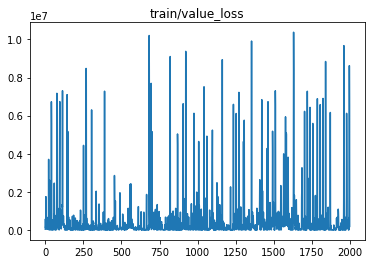

In [5]:
i = 2
df[df.columns[i]].plot(title=df.columns[i])
plt.show()

In [ ]:
# Plot mean rewards over training
reward_array_aggr = train_df.reward.to_numpy().reshape(-1, 96)

# Take the mean along the specified axis (axis=1 means take mean along columns)
reward_array_mean = np.mean(reward_array_aggr, axis=1)
plt.plot(reward_array_mean)
plt.title("mean reward over training process")
plt.show()

In [10]:
raise Exception("Stopping notebook execution here")

Exception: Stopping notebook execution here

## Model saving & loading

In [ ]:
# Save the trained model
model.save("models/microgrid_a2c_model_v4")

# PPO
# v1 -> lr=0.03, ent_coef=0.5, steps=200_000; discrete, binary for working status and purchased, discrete with = 6 for rest
# v2 -> lr=default, ent_coef=default, steps=200_000; discrete, binary for working status and purchased, discrete with = 6 for rest
# v3 -> lr=default, ent_coef=0.2, steps=200_000; discrete with = 5, binary only for purchased
# v4 -> lr=default, ent_coef=0.2, steps=200_000; discrete with = 5, binary only for purchased + positive costs as rewards
# v5 -> default, discretized 11, steps=1_000_000

# A2C
# v1 -> default params, 50_000 steps, corrected costs of producers
# v2 -> default params, 100_000 steps, ent_coef=0.1
# v3 -> discrete_steps_actions = 10, redefined initial values, ent_coef=0.2, 1_000_000 steps
# v4 -> default, disc 11, steps=1_000_000

In [7]:
# Load the trained model (if needed)
model = PPO.load("models/microgrid_a2c_model_v4")

## Testing

In [8]:
# Test the trained agent
test_episodes = 1000
max_length = len(data_dict["energy_demand"])
if test_episodes > max_length:
    raise Exception(f"episodes must be smaller { max_length }")

obs = env.reset()
step_info = []

for _ in range(test_episodes):  # Test for 1000 steps
    action, _ = model.predict(obs)
    obs, reward, done, info = env.step(action)

    step_info.append(env.render())
    
step_df = pd.DataFrame.from_dict(step_info)

In [11]:
action

array([ 1,  0,  1,  2,  0,  5,  9,  5, 10,  4,  3,  5,  8, 10,  3])

## Close

In [ ]:
# Close the environment when done
env.close()

## Analysis

In [9]:
step_df.drop(step_df.columns[7:20], axis=1).head(15)

,reward,operational_cost,sell_back_reward,energy_demand,energy_load,discharged,energy_purchased,actions_adjusting_status,soc,solar_irradiance,wind_speed,energy_price_utility_grid
0,-12.444914,0.002711,0.000000,20.737006,20.737006,0.000000,"{'load': 1, 'battery': 0}","{'solar': 0.5, 'wind': 0.0, 'generator': 0.0}",15.002660,0.1291,43.128,0.6
1,-10.629225,0.006018,0.000361,17.710416,17.710416,0.002660,"{'load': 1, 'battery': 0}","{'solar': 0.9, 'wind': 0.0, 'generator': 0.0}",15.000000,0.1592,45.900,0.6
2,-10.005773,0.001785,0.000802,16.678662,16.678662,0.000000,"{'load': 1, 'battery': 0}","{'solar': 0.5, 'wind': 0.0, 'generator': 0.0}",15.000000,0.0850,46.872,0.6
3,-109.908309,0.000000,0.000238,16.515436,16.515436,0.000000,"{'load': 1, 'battery': 0}","{'solar': 0.5, 'wind': 0.0, 'generator': 0.0}",15.000000,0.0000,47.340,0.6
4,-172.101519,0.000000,0.000000,16.835866,16.835866,0.000000,"{'load': 1, 'battery': 1}","{'solar': 0.9, 'wind': 0.0, 'generator': 0.0}",285.000000,0.0000,40.608,0.6
5,-172.102399,0.000880,0.000000,19.266111,150.000000,150.000000,"{'load': 1, 'battery': 0}","{'solar': 0.8, 'wind': 0.0, 'generator': 0.0}",127.105263,0.0000,42.732,0.6
6,-172.106800,0.005281,0.000000,26.730038,112.105263,112.105263,"{'load': 1, 'battery': 0}","{'solar': 0.8, 'wind': 0.0, 'generator': 0.0}",15.000000,0.1376,28.584,0.6
7,-182.955171,0.023572,0.000616,34.887025,34.887025,0.000000,"{'load': 1, 'battery': 0}","{'solar': 0.9, 'wind': 0.0, 'generator': 0.0}",15.002928,0.6236,23.040,0.6
8,-184.108167,2.126285,0.009429,33.321779,33.321779,0.002928,"{'load': 1, 'battery': 0}","{'solar': 0.8, 'wind': 0.0, 'generator': 0.0}",15.014775,63.2823,19.692,0.6
9,-184.463761,8.002038,0.283505,28.842726,28.842726,0.014775,"{'load': 1, 'battery': 0}","{'solar': 0.8, 'wind': 0.0, 'generator': 0.0}",25.772401,238.1539,19.476,0.6


In [10]:
step_df.iloc[:,7:20].head(15)

,energy_battery_discharged,energy_generated_solar,solar_load,solar_battery,solar_sell,energy_generated_wind,wind_load,wind_battery,wind_sell,energy_generated_generator,generator_load,generator_battery,generator_sell
0,0.000000,0.018074,0.000000,0.002800,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.002660,0.040118,0.001807,0.000000,0.001807,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.000000,0.011900,0.004012,0.000000,0.004012,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.001190,0.000000,0.001190,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
5,150.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
6,112.105263,0.030822,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
7,0.000000,0.157147,0.000000,0.003082,0.003082,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
8,0.002928,14.175235,0.000000,0.015715,0.047144,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
9,0.014775,53.346474,4.252571,11.340188,1.417524,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


In [11]:
# Count blackouts
print("absolute:", sum(step_df.energy_demand > step_df.energy_load))
print("relative:", sum(step_df.energy_demand > step_df.energy_load) / test_episodes)

absolute: 16
relative: 0.016


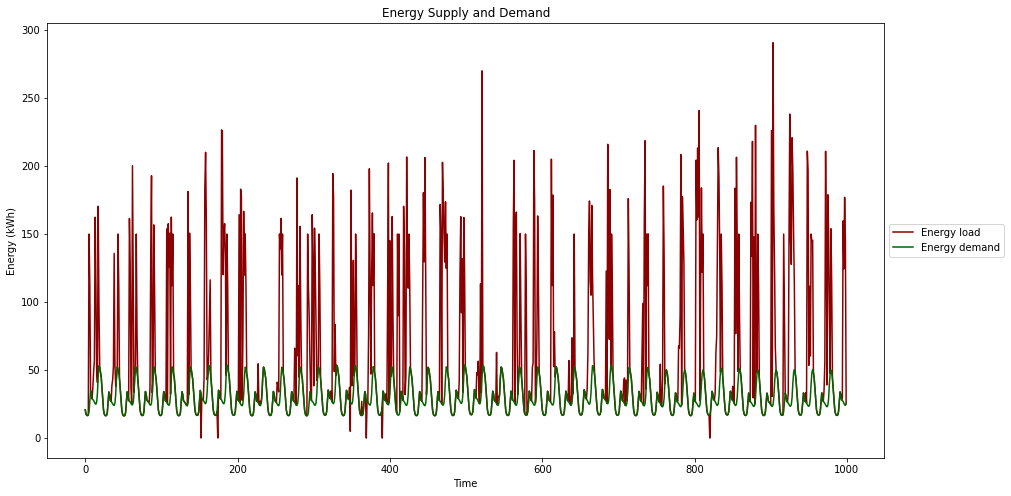

In [12]:
# Plotting energy demand and load
plt.rcParams["figure.figsize"] = (15,8)

#plt.plot(step_df['energy_generated_solar'], color='orange', label='Energy produced')
plt.plot(step_df['energy_load'], color='darkred', label='Energy load')
plt.plot(step_df['energy_demand'], color='darkgreen', label='Energy demand')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Energy (kWh)')
plt.title('Energy Supply and Demand')

# Moving legend outside to the right and centering
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

In [ ]:
step_df.columns

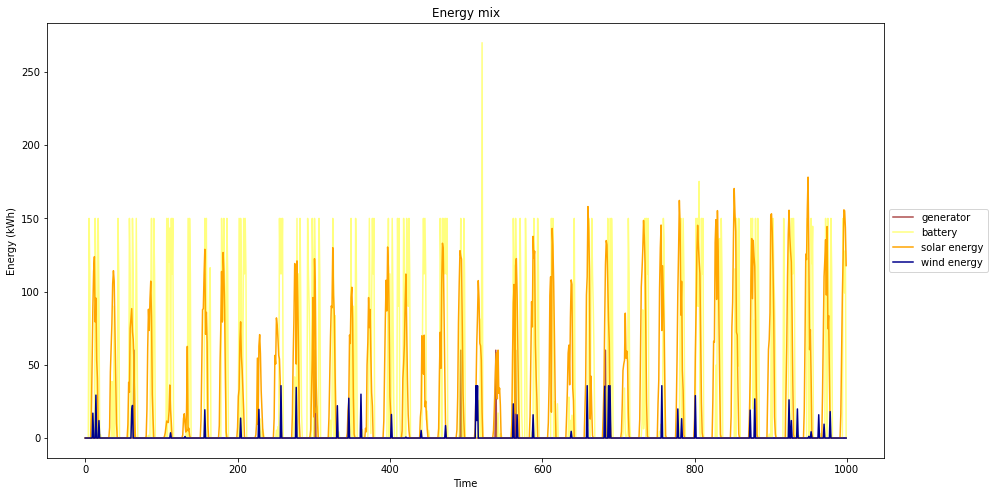

In [13]:
# Plotting energy produced
plt.plot(step_df['energy_generated_generator'], color='darkred', label='generator', alpha=0.7)
plt.plot(step_df['discharged'], color='yellow', label='battery', alpha=0.5)
plt.plot(step_df['energy_generated_solar'], color='orange', label='solar energy', alpha=1)
plt.plot(step_df['energy_generated_wind'], color='darkblue', label='wind energy', alpha=1)

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Energy (kWh)')
plt.title('Energy mix')

# Moving legend outside to the right and centering
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

In [ ]:
step_df.columns

<Axes: >

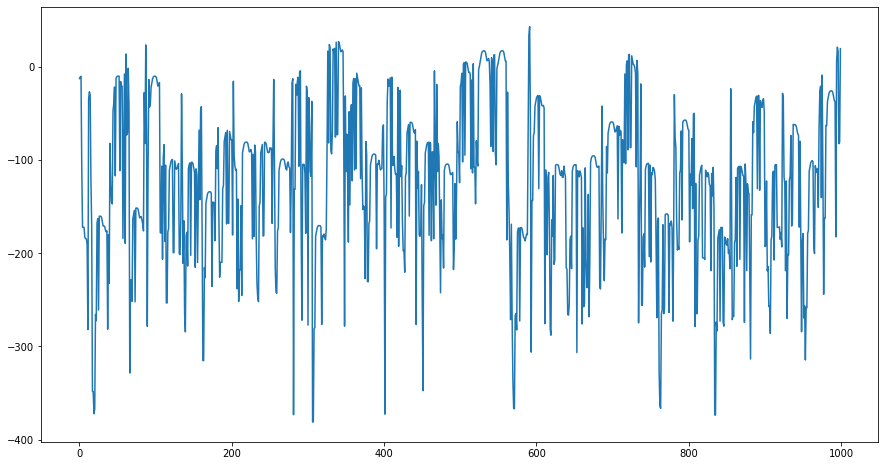

In [14]:
col = "reward"
step_df[col].plot()

<Axes: >

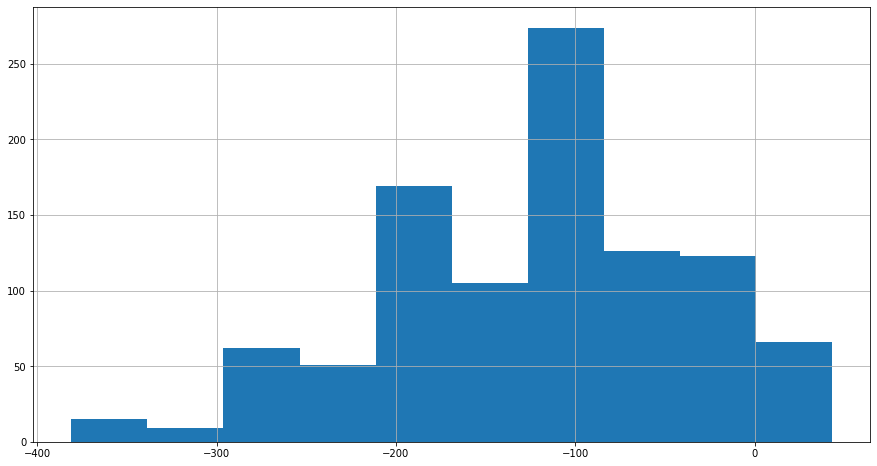

In [15]:
step_df[col].hist()